In [1]:
import sparknlp
from pyspark.ml import PipelineModel, Pipeline
import sparknlp.annotator as sa
import sparknlp.base as sb
import sparknlp
from sparknlp import Finisher

In [2]:
import sys
sys.path.insert(0, '../')
from util import util_data_access

In [3]:
# download data
util_data_access.download_file('newssniffer-nytimes.db.gz', 'edit-pathways/dbs/newssniffer-nytimes.db.gz')
! gunzip newssniffer-nytimes.db.gz

gzip: newssniffer-nytimes.db already exists; do you wish to overwrite (y or n)? ^C


In [ ]:
# util_data_access.download_file('glove-100d-loc.tar.gz', 'spark-nlp/glove-100d-loc.tar.gz')
# ! tar -xzvf glove-100d-loc.tar.gz 

# Load Spark

In [5]:
from pyspark.sql import SparkSession
# spark = sparknlp.start()

spark = (
    SparkSession.builder
      .config("spark.executor.instances", "30")
      .config("spark.driver.memory", "20g")
      .config("spark.executor.memory", "20g")
      .config("spark.executor.cores", "5")
      .config("spark.kryoserializer.buffer.max", "2000M")
      .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.11:2.7.5")
      .getOrCreate()
)

In [6]:
spark

# Load Our Own Data

In [7]:
import sqlite3
import pandas as pd
from tqdm.auto import tqdm
import pyspark.sql.functions as F
# import unidecode

# conn = sqlite3.connect('../data/diffengine-diffs/db/newssniffer-nytimes.db')
conn = sqlite3.connect('newssniffer-nytimes.db')

df = pd.read_sql('''
     SELECT * from entryversion 
     WHERE entry_id IN (SELECT distinct entry_id FROM entryversion LIMIT 5)
 ''', con=conn)

df = df.assign(summary=lambda df: df['summary'].str.replace('</p><p>', ' '))

In [8]:
sdf = spark.createDataFrame(df)

# With Sentences

In [9]:
from pyspark.ml.feature import Normalizer, SQLTransformer
from pyspark.ml.feature import BucketedRandomProjectionLSH
from scipy.spatial import distance
from pyspark.sql.types import FloatType
from scipy.spatial import distance

In [10]:
documenter = (
    sb.DocumentAssembler()
        .setInputCol("summary")
        .setOutputCol("document")
)

sentencer = (
    sa.SentenceDetector()
        .setInputCols(["document"])
        .setOutputCol("sentences")            
)

tokenizer = (
    sa.Tokenizer()
        .setInputCols(["sentences"])
        .setOutputCol("token")
)

word_embeddings = (
    sa.BertEmbeddings
        .load('s3://aspangher/spark-nlp/small_bert_L4_128_en_2.6.0_2.4')
        .setInputCols(["sentences", "token"])
        .setOutputCol("embeddings")
        .setMaxSentenceLength(512)
        .setBatchSize(100)
)

tok_finisher = (
    Finisher()
    .setInputCols(["token"])
    .setIncludeMetadata(True)
)

embeddings_finisher = (
    sb.EmbeddingsFinisher()
            .setInputCols("embeddings")
            .setOutputCols("embeddings_vectors")
            .setOutputAsVector(True)
)

In [39]:
zip_tok = (
    SQLTransformer()
     .setStatement("""
         SELECT entry_id, version, ARRAYS_ZIP(finished_token, finished_token_metadata, embeddings_vectors) AS zipped_tokens
         FROM __THIS__
    """)
)

explode_tok = (
    SQLTransformer()
     .setStatement("""
         SELECT entry_id, version, POSEXPLODE(zipped_tokens) AS (word_idx, zipped_token)
         FROM __THIS__
    """)
)

rename_tok = (
    SQLTransformer()
     .setStatement("""
         SELECT entry_id, 
                 version,
                 zipped_token.finished_token_metadata._2 AS sent_idx,
                 word_idx,
                 zipped_token.finished_token AS token,
                 zipped_token.embeddings_vectors as word_embedding
         FROM __THIS__
    """)
) 

vector_normalizer = Normalizer(inputCol="word_embedding", outputCol="norm_word_embedding", p=2.0)
similarty_checker = BucketedRandomProjectionLSH(inputCol="norm_word_embedding", outputCol="hashes", bucketLength=6.0, numHashTables=6)

def cosine_distance(x, y):
    return float(distance.cosine(x, y))
spark.udf.register("cosine_distance", cosine_distance, "float")

inner_join = (
    SQLTransformer()
     .setStatement("""
         SELECT word_emb.entry_id                                                    AS entry_id, 
                 word_emb.version                                                    AS version_x,
                 word_emb_2.version                                                  AS version_y,
                 word_emb.sent_idx                                                   AS sent_idx_x,
                 word_emb_2.sent_idx                                                 AS sent_idx_y,
                 word_emb.word_idx                                                   AS word_idx_x,
                 word_emb_2.word_idx                                                 AS word_idx_y,
                 word_emb.token                                                      AS token_x,
                 word_emb_2.token                                                    AS token_y,
                 cosine_distance(word_emb.word_embedding, word_emb_2.word_embedding) AS cosine_distance
         FROM __THIS__ word_emb
         JOIN __THIS__ word_emb_2
         ON word_emb.entry_id = word_emb_2.entry_id and
         word_emb.version + 1 = word_emb_2.version
    """)
) 

#                  CONCAT(word_emb.entry_id, '-', 
#                         word_emb.version, '-',
#                         word_emb_2.version, '-',
#                         word_emb.sent_idx, '-',
#                         word_emb_2.sent_idx, '-',
#                         word_emb.word_idx, '-',
#                         word_emb_2.word_idx, '-',
#                         word_emb.token, '-'
#                         )                                                            AS partition_key,

In [59]:
get_word_pair_min_distance = (
    SQLTransformer()
     .setStatement("""
         SELECT entry_id,
                version_x,
                version_y,
                sent_idx_x,
                sent_idx_y,
                word_idx_x,
                MIN(distance) as min_word_distance
        FROM __THIS__ 
        GROUP BY entry_id,
                    version_x,
                    version_y,
                    sent_idx_x,
                    sent_idx_y,
                    word_idx_x
      """)
)

get_sentence_min_distance = (
    SQLTransformer()
     .setStatement("""
         SELECT entry_id,
                version_x,
                version_y,
                sent_idx_x,
                sent_idx_y,
                AVG(min_word_distance) as avg_sentence_distance
        FROM __THIS__ 
        GROUP BY entry_id,
                    version_x,
                    version_y,
                    sent_idx_x,
                    sent_idx_y
      """)
)

get_max_word_rn = (
    SQLTransformer()
     .setStatement("""
         SELECT * FROM (
             SELECT *, ROW_NUMBER() OVER (
                         PARTITION BY entry_id, 
                                      version_x, 
                                      version_y, 
                                      sent_idx_x, 
                                      sent_idx_y, 
                                      word_idx_x, 
                                      token_x 
                                      ORDER BY cosine_distance ASC
         ) AS rn FROM __THIS__)
         where rn = 1
    """)
)

In [41]:
similarity_pipeline = sb.RecursivePipeline(stages=[
    documenter,
    sentencer,
    tokenizer,
    word_embeddings,
    embeddings_finisher,
    tok_finisher,
    # 
    zip_tok,
    explode_tok,
    rename_tok,
    vector_normalizer,
    similarty_checker
    # 
#     inner_join,
    # get_max_word_min, ### too slow!!
    
  ]
)

In [42]:
word_emb_sdf = similarity_pipeline.fit(sdf).transform(sdf)

In [43]:
similarity_model = similarity_pipeline.fit(sdf)

In [49]:
word_emb_sdf = similarity_model.transform(sdf)

In [55]:
joined_df = (
    model
    .stages[10]
    .approxSimilarityJoin(word_emb_sdf, word_emb_sdf, .4, distCol="distance")
    .where((F.col("datasetA.entry_id") == F.col("datasetB.entry_id")) & (F.col("datasetA.version") + 1 == F.col("datasetB.version")))
    .select(
         F.col("datasetA.entry_id").alias("entry_id"),
         F.col("datasetA.version").alias("version_x"),
         F.col("datasetB.version").alias("version_y"),
         F.col("datasetA.sent_idx").alias("sent_idx_x"),
         F.col("datasetB.sent_idx").alias("sent_idx_y"),        
         F.col("datasetA.word_idx").alias("word_idx_x"),
         F.col("datasetB.word_idx").alias("word_idx_y"),
         F.col("datasetA.token").alias("token_x"),
         F.col("datasetB.token").alias("token_y"),
         F.col("distance")
    )
)

In [58]:
get_word_pair_min_distance.transform(joined_df).show()

+--------+---------+---------+----------+----------+----------+-------------------+
|entry_id|version_x|version_y|sent_idx_x|sent_idx_y|word_idx_x|      min(distance)|
+--------+---------+---------+----------+----------+----------+-------------------+
|  547990|        0|        1|        31|        54|       625|0.27467247689876834|
|  547990|        0|        1|       110|        69|      2392| 0.3241328806506398|
|  547991|        0|        1|        23|        23|       641|0.25599765822360915|
|  547991|        2|        3|        44|        44|      1069|                0.0|
|  547991|        2|        3|        52|        53|      1328|                0.0|
|  547991|        2|        3|        39|        40|       927|0.34708298864380505|
|  547990|        0|        1|       113|       113|      2503|                0.0|
|  547990|        0|        1|         9|         9|       212|                0.0|
|  547988|        0|        1|         3|         3|       106|             

In [34]:
word_emb_sdf = word_emb_sdf.cache()

In [ ]:
word_emb_sdf = word_emb_sdf.repartition('entry_id', 'version_x', 'version_y', 'sent_idx_x', 'sent_idx_y')#, 'word_idx_x')

In [ ]:
word_emb_sdf.show()

In [17]:
word_emb_sdf = get_max_word_min.transform(word_emb_sdf)

In [21]:
from pyspark.sql.functions import spark_partition_id, asc, desc
partitions = (
    word_emb_sdf
        .withColumn("partitionId", spark_partition_id())
        .groupBy("partitionId")
        .count()
        .orderBy(asc("count"))
        .toPandas()
)

In [23]:
partitions['count'].sum()

755380

In [18]:
word_emb_sdf.show()

+--------+---------+---------+----------+----------+----------+--------------------+
|entry_id|version_x|version_y|sent_idx_x|sent_idx_y|word_idx_x|min(cosine_distance)|
+--------+---------+---------+----------+----------+----------+--------------------+
|  547991|        2|        3|         0|        23|         0|          0.45366806|
|  547991|        2|        3|         0|        23|         1|          0.31662515|
|  547991|        2|        3|         0|        23|         2|          0.32143697|
|  547991|        2|        3|         0|        23|         3|          0.32374802|
|  547991|        2|        3|         0|        23|         4|          0.34763005|
|  547991|        2|        3|         0|        23|         5|           0.3871965|
|  547991|        2|        3|         0|        23|         6|          0.33349082|
|  547991|        2|        3|         0|        23|         7|          0.40576532|
|  547991|        2|        3|         0|        23|         8|  

In [ ]:
## todo: calculate num words per sentence.
## set a filter threshold to filter out any cosine distances that as > .4

In [163]:
# word_emb_sdf.write.mode("overwrite").parquet("s3://aspangher/tmp/tmp_bert_embeddings")

In [ ]:
sdf.shape

In [150]:
get_max_word_rn = (
    SQLTransformer()
     .setStatement("""
         SELECT *
         FROM (SELECT *, ROW_NUMBER() OVER (
                         PARTITION BY entry_id, 
                                      version_x, 
                                      version_y, 
                                      sent_idx_x, 
                                      sent_idx_y, 
                                      word_idx_x, 
                                      token_x 
                                      ORDER BY cosine_distance ASC
                                      ) AS rn FROM __THIS__)
         where rn = 1
    """)
) 

get_max_word_cross = (
    SQLTransformer()
     .setStatement("""
         SELECT t1.token_x FROM __THIS__ AS t1
         CROSS APPLY
             (select TOP 1 cosine_distance
              from __THIS__ t2
              WHERE t1.entry_id = t2.entry_id
              AND t1.version_x = t2.version_x
              AND t1.version_y = t2.version_y
              AND t1.sent_idx_x = t2.sent_idx_x
              AND t1.sent_idx_y = t2.sent_idx_y
              AND t1.word_idx_x = t2.word_idx_x
              AND t1.token_x = t2.token_x
              order by cosine_distance ASC) as t2
      """)
)

In [ ]:
(inner_join_df
 ## get max words
 .loc[lambda df: df.groupby(['entry_id_x', 'version_x', 'sent_idx_x', 'sent_idx_y', 'word_idx_x', 'token_x'])['dot_product'].idxmax()][des_col_list]
 ## get mean of sentence
 .groupby(['entry_id_x', 'version_x', 'sent_idx_x', 'version_y', 'sent_idx_y'])['dot_product'].mean().reset_index()
 ## get max sentence
 .loc[lambda df: df.groupby(['entry_id_x', 'version_x', 'sent_idx_x', 'version_y'])['dot_product'].idxmax()]
)

In [46]:
from tqdm.auto import tqdm

In [128]:
import numpy as np 
import matplotlib.pyplot as plt 

In [129]:
c, b = np.histogram(inner_join_df['dot_product'], bins=100)

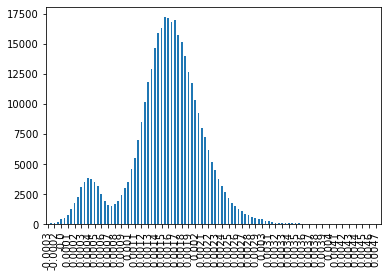

In [130]:
hist_plot = pd.Series({b_i:c_i for c_i, b_i in zip(c, b[:-1])})
hist_plot.plot(kind='bar')
plt.xticks(range(len(hist_plot))[::2], list(map(lambda x: round(x, 4), hist_plot.index))[::2]);

In [133]:
(inner_join_df
 .groupby(['entry_id_x', 'version_x', 'sent_idx_x', 'sent_idx_y', 'word_idx_x', 'token_x'])
 ['dot_product'].idxmax()
 .head(3)
)

entry_id_x  version_x  sent_idx_x  sent_idx_y  word_idx_x  token_x   
547989      0          0           0           0           WASHINGTON       0
                                               1           —              608
                                               2           Weapons       1216
Name: dot_product, dtype: int64

In [134]:
max_words = (inner_join_df
 .loc[lambda df: df.groupby(['entry_id_x', 'version_x', 'sent_idx_x', 'sent_idx_y', 'word_idx_x', 'token_x'])['dot_product'].idxmax()]
 [des_col_list]
 .groupby([
     'entry_id_x', 'version_x', 'sent_idx_x', 'version_y', 'sent_idx_y'
 ])['dot_product']
 .mean()
 .reset_index()
 .loc[lambda df: df.groupby(['entry_id_x', 'version_x', 'sent_idx_x', 'version_y'])['dot_product'].idxmax()]
 .sort_values('sent_idx_x')
#  .loc[lambda df: df['sent_idx_x'] != df['sent_idx_y']]
)